# Set up

In [1]:
import os

2023-09-05 13:11:21.886181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Colab execution settings

colab = 'COLAB_RELEASE_TAG' in os.environ

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/HDA_Project/HDA_project')
    !git pull
    dataset_dir = '/content/drive/MyDrive/HDA_Project/Project_6'
    

else:
    dataset_dir = '/Users/lucaagosti/Human_Data_Analytics/Project_6'

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

from models import EfficientNet, Inception_v4, ResNet50, CNN
from lymphoma_dataset import LymphomaDataset

In [3]:
#Handle GPU memory usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        #print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Parameters and data augmentation

In [4]:
#Parameters and dataset kwargs definition
seed = 2023
#dataset_dir = '/Users/lucaagosti/Human_Data_Analytics/Project_6'
color_space = 'rgb' # 'rgb' or 'gray' or 'lab' or 'hed'
batch_size = 32 # number of patches per batch
patch_size = 299 # size of the patches
patch_stride = patch_size // 2 # if equal to PATCH_SIZE, no overlap
train_val_test_split = [0.6, 0.2, 0.2] # train, val, test split fractions
color_channels = 1 if color_space == 'gray' else 3

preprocess_fn_kwargs = {'patch_sizes': [1, patch_size, patch_size, 1], 
                        'patch_strides': [1, patch_stride, patch_stride, 1],
                        'patch_rates': [1, 1, 1, 1], 
                        'patch_padding': 'VALID',
                        'color_space': color_space}

dataset_kwargs = {'batch_size': batch_size,
                  'cache_file': 'cache_' + color_space + '_' + str(patch_size), # if 'memory', the dataset will be cached in memory (risk of OOM)
                  'shuffle': True, # whether to shuffle the dataset, set it to false to get predictions for each image
                  'buffer_size': 10*batch_size,
                  'num_parallel_calls': 2, # enough to saturate the GPU compute capabilities
                  'extract_patches': True, # if False, the dataset will return the whole image
                  'reshape_patches': True} # if False returns a 5D tensor (batch, num_patches, patch_size, patch_size, channels) instead of a 4D tensor (batch*num_patches, patch_size, patch_size, channels)

In [5]:
#Data augmentation
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.RandomFlip('horizontal_and_vertical', seed=seed), # flip horizontally and vertically
                    tf.keras.layers.RandomTranslation(0.1, 0.1, seed=seed), # -10% to 10% translation
                    tf.keras.layers.RandomRotation(0.5, seed=seed) # -90 to 90 degrees
])

dataset = LymphomaDataset(dataset_path=dataset_dir, 
                          data_augmentation=data_augmentation,
                          preprocess_fn_kwargs=preprocess_fn_kwargs, 
                          dataset_kwargs=dataset_kwargs,
                          train_val_test_split=train_val_test_split, 
                          seed=seed)

num_patches_per_image = dataset.num_patches_per_image

In [6]:
#Train, validation, test sets split
train_dataset, val_dataset, test_dataset = dataset.get_datasets()
train_steps, val_steps, test_steps = dataset.get_steps()

(32, 299, 299, 3) (32,)


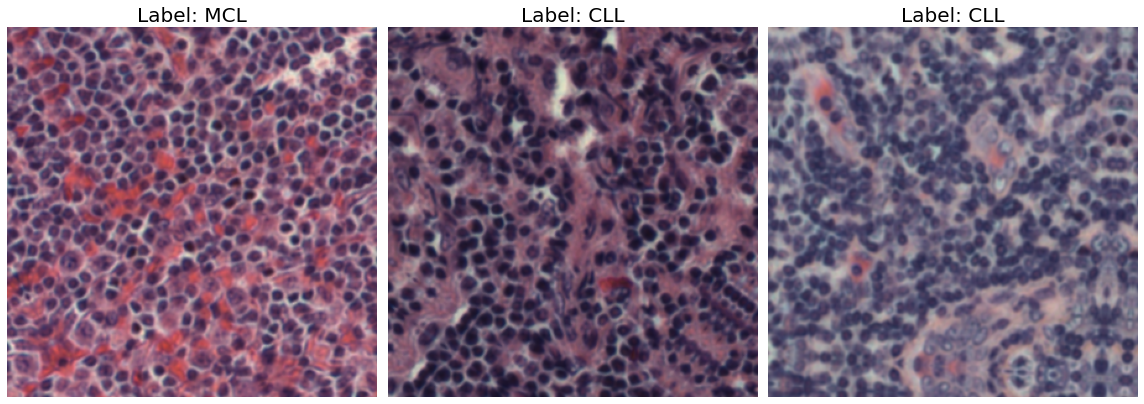

(32, 299, 299, 3) (32,)


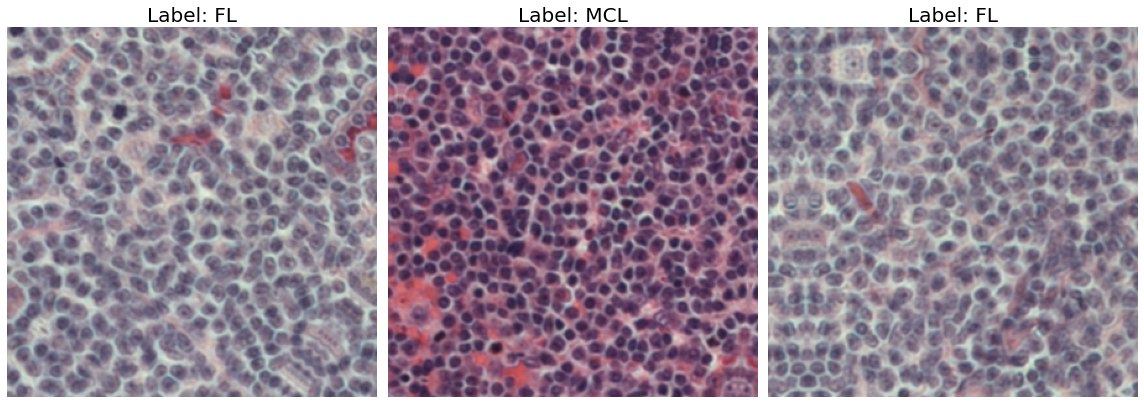

(32, 299, 299, 3) (32,)


2023-09-05 13:11:41.380612: W tensorflow/core/kernels/data/cache_dataset_ops.cc:298] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


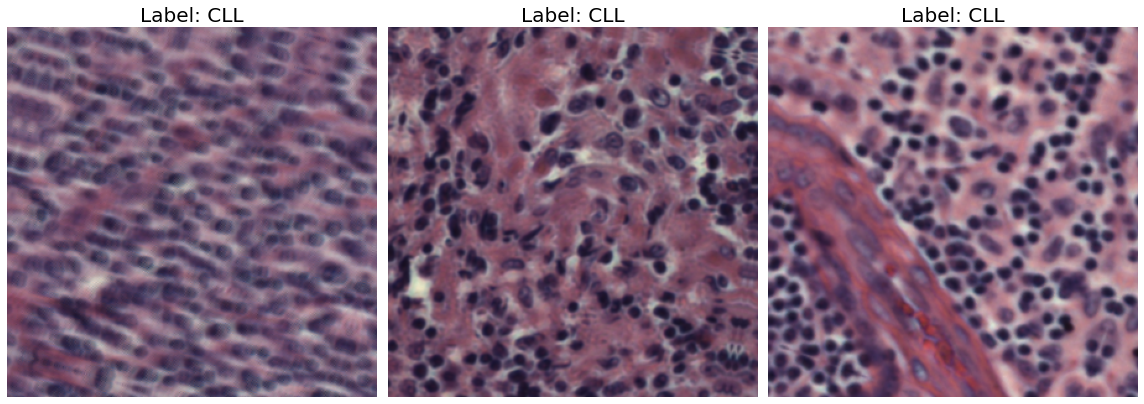

In [7]:
#A look to the dataset to check if everything works
import matplotlib.pyplot as plt

cmap = 'gray' if color_space == 'gray' else None

for patches, labels in train_dataset.take(3):
    fig, axes = plt.subplots(1, 3, figsize=(16,16))
    print(patches.shape, labels.shape)
    for i in range(1):
        for j in range(3):
            axes[j].imshow(patches[i*8+j, :, :, :], cmap=cmap)
            label = labels[i*8+j]
            if label == 0:
                label = 'CLL'
            elif label == 1:
                label = 'FL'
            else:
                label = 'MCL'
            axes[j].title.set_text(f'Label: {label}')
            # increses the size of the title
            axes[j].title.set_fontsize(20)

    # hide the axis
    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Model

In [8]:
#Which model do you want to study?
# model = CNN(input_shape=(PATCH_SIZE, PATCH_SIZE, INPUT_CHANNELS), filters=(64,128,256,512), compression_depth=4)
model = Inception_v4(input_shape=(patch_size, patch_size, color_channels))


In [9]:
model.summary()

Model: "Inception_v4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv_stem_1 (Conv2D)        (None, 149, 149, 32)         896       ['input_1[0][0]']             
                                                                                                  
 bn_stem_1 (BatchNormalizat  (None, 149, 149, 32)         128       ['conv_stem_1[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['bn_stem_1[0][0]']

In [10]:
#Training parameters
metrics = ['accuracy']

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                    factor=0.2, patience=5, 
                                                    verbose=1, 
                                                    min_lr=1e-5)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience=10, 
                                                  restore_best_weights=True)

In [11]:
#Checkpoint file
checkpoint_path = './inception/inception'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                monitor='val_accuracy',
                                                mode='max',
                                                save_best_only=True,
                                                verbose=1)

#Backup file
backup_path = './inception_backup'
backup = tf.keras.callbacks.BackupAndRestore(backup_dir=backup_path,
                                             save_freq='epoch',
                                             delete_checkpoint=True)

#Logger
logger = tf.keras.callbacks.CSVLogger('inception.csv', separator=',', append=True)

In [12]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
history = model.fit(train_dataset, 
                    epochs=4, 
                    steps_per_epoch=train_steps,
                    validation_data=val_dataset, 
                    validation_steps=val_steps,
                    callbacks=[lr_scheduler, early_stopping, checkpoint, backup, logger])

hist = history.history

Epoch 1/4


RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InvalidArgumentError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tensorflow/python/framework/errors_impl.py(286): __init__
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tensorflow/python/framework/ops.py(2280): get_attr
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tensorflow/python/framework/auto_control_deps_utils.py(105): get_read_write_resource_inputs
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tensorflow/python/framework/auto_control_deps.py(608): _get_resource_inputs
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tensorflow/python/framework/auto_control_deps.py(459): __exit__
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tensorflow/python/framework/func_graph.py(987): func_graph_from_py_func
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/tracing_compiler.py(305): _create_concrete_function
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/tracing_compiler.py(398): _maybe_define_function
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/tracing_compiler.py(147): __call__
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(890): _call
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(825): __call__
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/keras/src/engine/training.py(1742): fit
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py(65): error_handler
  /var/folders/d9/l010djr96qz348jggwyvstn00000gn/T/ipykernel_7596/4067710789.py(1): <cell line: 1>
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3361): run_code
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3301): run_ast_nodes
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3098): run_cell_async
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/IPython/core/interactiveshell.py(2900): _run_cell
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/IPython/core/interactiveshell.py(2854): run_cell
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/ipykernel/zmqshell.py(532): run_cell
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/ipykernel/ipkernel.py(360): do_execute
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/ipykernel/kernelbase.py(662): execute_request
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/ipykernel/kernelbase.py(367): dispatch_shell
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/ipykernel/kernelbase.py(460): process_one
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/ipykernel/kernelbase.py(471): dispatch_queue
  /usr/local/Cellar/python@3.10/3.10.2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py(80): _run
  /usr/local/Cellar/python@3.10/3.10.2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py(1881): _run_once
  /usr/local/Cellar/python@3.10/3.10.2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py(595): run_forever
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/tornado/platform/asyncio.py(199): start
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/ipykernel/kernelapp.py(677): start
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/traitlets/config/application.py(846): launch_instance
  /usr/local/Cellar/ipython/8.1.1/libexec/lib/python3.10/site-packages/ipykernel_launcher.py(16): <module>
  /usr/local/Cellar/python@3.10/3.10.2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py(86): _run_code
  /usr/local/Cellar/python@3.10/3.10.2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py(196): _run_module_as_main


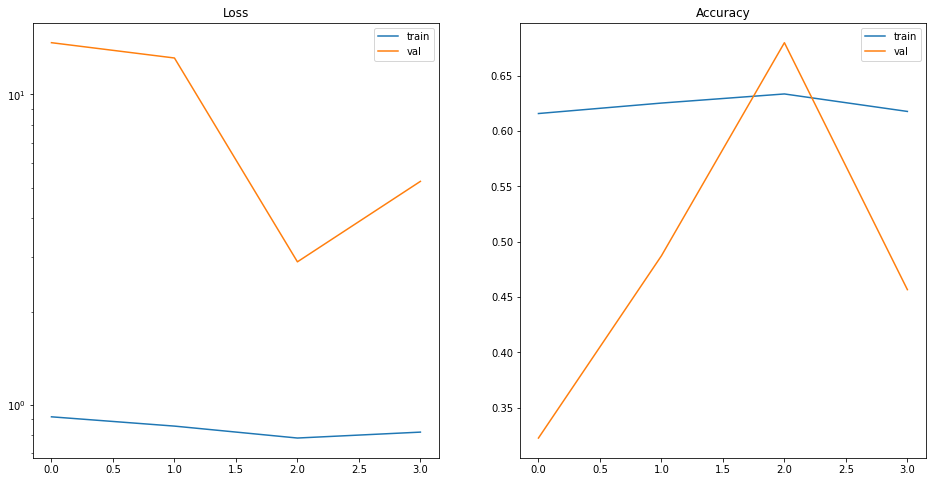

In [ ]:
# Loss and accuracy for training and validation test
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].plot(hist['loss'], label='train')
axes[0].plot(hist['val_loss'], label='val')
axes[0].set_title('Loss')
axes[0].set_yscale('log')
axes[0].legend()
axes[1].plot(hist['accuracy'], label='train')
axes[1].plot(hist['val_accuracy'], label='val')
axes[1].set_title('Accuracy')
axes[1].legend()
